### Problem Statement: A Retail Company has introduced “Buy now pay later” (BNPL) feature within the mobile app platform. We need to predict if a customer will ignore or enroll in the BNPL feature. 
##### (This is a binary classification problem)

### EDA

##### Importing required libraries and reading the data for EDA

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import keras

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the files and converting to dataframe
df_mobileusebasedata = pd.read_csv('mobileusebasedata.csv')
df_most_used_screens = pd.read_csv('most_used_screens.csv')

In [3]:
print('shape for df_most_used_screens data is : ',df_most_used_screens.shape)
print('shape for df_mobileusebasedata data is : ',df_mobileusebasedata.shape)

shape for df_most_used_screens data is :  (58, 2)
shape for df_mobileusebasedata data is :  (50000, 12)


In [4]:
print('sample data in df_mobileusebasedata : \n')
df_mobileusebasedata.head(4)

sample data in df_mobileusebasedata : 



,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0


In [5]:
print('sample data in df_most_used_screens : \n')
df_most_used_screens.head(4)

sample data in df_most_used_screens : 



,Unnamed: 0,top_screens
0,0,Loan2
1,1,location
2,2,Institutions
3,3,Credit3Container


In [6]:
# Standardizing the screen names in the dataset to lower case and removing space
df_most_used_screens['top_screens_cleaned']=df_most_used_screens['top_screens'].apply(lambda x : x.lower().replace(' ',''))

In [7]:
print('sample data in df_most_used_screens : \n')
df_most_used_screens.head()

sample data in df_most_used_screens : 



,Unnamed: 0,top_screens,top_screens_cleaned
0,0,Loan2,loan2
1,1,location,location
2,2,Institutions,institutions
3,3,Credit3Container,credit3container
4,4,VerifyPhone,verifyphone


##### Checking for duplicates

In [8]:
# checking duplication at user level
print('Total records in the dataset = ',df_mobileusebasedata.shape[0])
print('Number of unique users in the dataset = ',df_mobileusebasedata.user.nunique())
print('There seems to be some duplication. This is just 0.2% [126 out of 50000 records] hence I will drop the duplicates')
df_mobileusebasedata_dup_removed = df_mobileusebasedata.drop_duplicates(subset=['user'])

Total records in the dataset =  50000
Number of unique users in the dataset =  49874
There seems to be some duplication. This is just 0.2% [126 out of 50000 records] hence I will drop the duplicates


##### Below I will do the following processing:- 
- Creating a dataset from the df_mobileusebasedata_dup_removed , using column screen_list to expand that in multiple columns
- To get different screen_list present across all users.
- Standardize the 'screen_list' column as well to lower case

In [9]:
def function_to_create_columns_from_screen_list(df):
    df['screen_list_cleaned']=df['screen_list'].apply(lambda x : x.lower())
    df['screen_list_cleaned'] = df['screen_list_cleaned'].str.split(',')
    df = df.explode('screen_list_cleaned', ignore_index=True)
    df['Value']=1
    pivot_df = df.pivot_table(index='user', columns=['screen_list_cleaned'], values='Value',aggfunc='sum', fill_value=0)
    pivot_df = pivot_df.reset_index().fillna('')
    print(pivot_df.shape)
    return(pivot_df)

In [10]:
# df_mobileusebasedata_dup_removed

In [11]:
df_mobileusebasedata_dup_removed_pivot=function_to_create_columns_from_screen_list(df_mobileusebasedata_dup_removed.copy())
df_mobileusebasedata_dup_removed_pivot

(49874, 138)


screen_list_cleaned,user,about,accountview,addproperty,addvehicle,adverseactions,alerts,bankverification,boostfriendslist,bvplaidlinkcontainer,...,verifyhousing,verifyhousingamount,verifyincometype,verifymobile,verifyphone,verifyssn,verifytoken,webview,welcomebankverification,yournetwork
0,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,48,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49869,373624,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49870,373628,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
49871,373633,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49872,373639,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [12]:
# 317454
# 235143
# 317171
# df_mobileusebasedata_dup_removed_col_expanded.loc[pivot_df.user==317171][['user','institutions','product_review']]

##### Keeping only relevant columns in the dataset for further processing

In [13]:
df_temp_1 = df_mobileusebasedata_dup_removed.drop(columns=['screen_list'])
df_mobileusebasedata_dup_removed_cols_expanded = df_temp_1.merge(df_mobileusebasedata_dup_removed_pivot, how='left', on='user')

In [14]:
df_mobileusebasedata_dup_removed_cols_expanded.shape

(49874, 148)

In [15]:
df_mobileusebasedata_dup_removed_cols_expanded.head()

,user,first_open,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,...,verifyhousing,verifyhousingamount,verifyincometype,verifymobile,verifyphone,verifyssn,verifytoken,webview,welcomebankverification,yournetwork
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,15,0,0,0,NaN,...,0,0,0,0,1,0,1,0,0,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,13,0,0,0,NaN,...,0,0,0,0,1,0,1,0,0,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,3,0,1,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,40,0,0,1,2013-07-05 16:11:49.513,...,0,0,0,0,1,1,0,0,0,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,32,0,0,1,2013-02-26 18:56:37.841,...,0,0,0,0,1,1,1,0,0,0


##### Checking null values and doing required processing

In [16]:
# function to check null values in the dataset
def check_empty_value(df):
    df = df.isna().sum().reset_index().rename(columns={0:'empty_counts', 'index':'column_name'})
    print('columns with empty values are :')
    print(df.loc[df.empty_counts>0])
print('before processing:' )
check_empty_value(df_mobileusebasedata_dup_removed_cols_expanded)
df_mobileusebasedata_dup_removed_cols_expanded_v3 = df_mobileusebasedata_dup_removed_cols_expanded.drop(columns=['enrolled_date']) #dropping this column as this column is not required

before processing:
columns with empty values are :
     column_name  empty_counts
9  enrolled_date         18870


In [17]:
print('min date in first open : ',df_mobileusebasedata_dup_removed_cols_expanded_v3['first_open'].min())
print('max date in first open : ',df_mobileusebasedata_dup_removed_cols_expanded_v3['first_open'].max())
print("'Tenure using the first_open is not useful column  hence dropping that")

df_mobileusebasedata_dup_removed_cols_expanded_v3=df_mobileusebasedata_dup_removed_cols_expanded_v3.drop(columns=['first_open'])

min date in first open :  2012-11-23 00:10:19.912
max date in first open :  2013-07-09 15:52:39.983
'Tenure using the first_open is not useful column  hence dropping that


### 

In [18]:
# converting hours to integer
df_mobileusebasedata_dup_removed_cols_expanded_v3['hour']=df_mobileusebasedata_dup_removed_cols_expanded_v3['hour'].apply(lambda x : int(x[:3]))

In [19]:
df_mobileusebasedata_dup_removed_cols_expanded_v3.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,about,...,verifyhousing,verifyhousingamount,verifyincometype,verifymobile,verifyphone,verifyssn,verifytoken,webview,welcomebankverification,yournetwork
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,333588,6,1,24,13,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,1,1,1,0,0,0


##### Correlation Analysis

In [20]:
correlation_matrix=df_mobileusebasedata_dup_removed_cols_expanded_v3.corr()

In [21]:
correlation_matrix

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,about,...,verifyhousing,verifyhousingamount,verifyincometype,verifymobile,verifyphone,verifyssn,verifytoken,webview,welcomebankverification,yournetwork
user,1.000000,-0.002563,-0.012519,-0.003425,0.000256,0.006438,0.004318,-0.000594,0.007386,0.003565,...,0.003102,0.002574,0.001037,-0.003294,0.005856,0.003023,0.004497,-0.004185,0.012313,-0.005881
dayofweek,-0.002563,1.000000,0.013028,-0.012227,0.008029,-0.008740,0.001741,0.010936,-0.005595,0.002906,...,0.000543,-0.000375,-0.000039,-0.005499,0.008773,0.000340,0.004475,-0.001991,-0.003753,-0.000799
hour,-0.012519,0.013028,1.000000,0.018857,-0.076607,-0.009037,0.022475,-0.066682,-0.001797,-0.002633,...,-0.020209,-0.021826,-0.020510,-0.018047,-0.060763,-0.062341,-0.041374,-0.005928,0.019788,-0.012699
age,-0.003425,-0.012227,0.018857,1.000000,-0.128545,0.020026,0.004199,-0.131316,-0.002432,0.004370,...,-0.009618,-0.009313,-0.004622,-0.015197,-0.139602,-0.148540,-0.126775,0.013539,0.043634,0.025629
numscreens,0.000256,0.008029,-0.076607,-0.128545,1.000000,0.040768,0.061770,0.209620,-0.007235,0.138575,...,0.350521,0.342807,0.256538,0.154340,0.387498,0.350637,0.353060,0.084242,-0.019787,0.053101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verifyssn,0.003023,0.000340,-0.062341,-0.148540,0.350637,0.016515,-0.005389,0.679326,-0.000922,-0.001954,...,0.040991,0.038505,0.044258,0.221926,0.607321,1.000000,0.417184,-0.027176,-0.080706,-0.023308
verifytoken,0.004497,0.004475,-0.041374,-0.126775,0.353060,-0.040581,-0.044997,0.265257,-0.003341,0.004070,...,0.069371,0.067590,0.063596,-0.025404,0.700910,0.417184,1.000000,-0.018839,-0.071446,-0.010259
webview,-0.004185,-0.001991,-0.005928,0.013539,0.084242,0.014586,0.027212,-0.065214,-0.002539,0.060200,...,0.012139,0.012022,0.008117,-0.034088,-0.012733,-0.027176,-0.018839,1.000000,0.000774,-0.009398
welcomebankverification,0.012313,-0.003753,0.019788,0.043634,-0.019787,-0.014046,-0.005729,-0.101697,0.000420,0.003464,...,-0.005461,-0.005836,-0.006085,-0.018804,-0.090559,-0.080706,-0.071446,0.000774,1.000000,0.009326


In [22]:
print('Highly correlated columns with independent columns are : \n')

for i,col in enumerate(correlation_matrix.columns):
    if col=='enrolled':
        print(correlation_matrix.loc[(correlation_matrix['enrolled']>0.6)&(correlation_matrix['enrolled']!=1),['enrolled']])
    else:
        pass
    

Highly correlated columns with independent columns are : 

           enrolled
verifyssn  0.679326


In [23]:
print('Highly correlated columns with among dependent columns are : \n')

for i,col in enumerate(correlation_matrix.columns):
    if col=='enrolled':
        pass
    else:
        print('Highly correlated column with [',col,'] is : ')
        print(correlation_matrix.loc[(correlation_matrix[col]>0.6) & (correlation_matrix[col]!=1),[col]])
        print('----------------------------------------------')
    

Highly correlated columns with among dependent columns are : 

Highly correlated column with [ user ] is : 
Empty DataFrame
Columns: [user]
Index: []
----------------------------------------------
Highly correlated column with [ dayofweek ] is : 
Empty DataFrame
Columns: [dayofweek]
Index: []
----------------------------------------------
Highly correlated column with [ hour ] is : 
Empty DataFrame
Columns: [hour]
Index: []
----------------------------------------------
Highly correlated column with [ age ] is : 
Empty DataFrame
Columns: [age]
Index: []
----------------------------------------------
Highly correlated column with [ numscreens ] is : 
Empty DataFrame
Columns: [numscreens]
Index: []
----------------------------------------------
Highly correlated column with [ minigame ] is : 
Empty DataFrame
Columns: [minigame]
Index: []
----------------------------------------------
Highly correlated column with [ used_premium_feature ] is : 
Empty DataFrame
Columns: [used_premium_featu

##### Variable reduction post correlation analysis

Similarly named columns can be combined to reduce correlation among independent variables.

verifyssn seems to be highly correlated with enrolled, so keeping that separate to get better predictability

In [24]:
list_loan=['loanappschedulecall','loanappwithdrawn','loanappdenied','loanappesign','loanappconfirmwithdrawal','loan4','loanapploan4','loanapprequestamount','llloanamount','loanappsuccess','loan2','loanappbankinfo','loanappverifybankinfo','loanapppaymentschedule','loanappagreement','loan1','loanappreasons','instantloanssn','loan','loanapppromocode','loan3']
list_credit=['credit3alerts','credit2','credit3container','credit3','credit1','reviewcreditcard','credits','credit3dashboard','credit3cta']
list_verification=['verifybankinfo','bankverification','welcomebankverification','verifyincometype','verifycountry','profileverifyssn','verifymobile','verifyphone','verifyannualincome','verifydateofbirth','verifyhousing','profileverifyincometype','verifyhousingamount','verifytoken','identityverification']
list_profile=['editprofile','profileproduct_review','profilechildren','profileeducation','profileemploymentlength','profileannualincome','profilepage','profilecompanyname','profilemaritalstatus','profilejobtitle','profileeducationmajor']
list_saving=['savinggoalincomesalary','saving8','saving4','saving6','saving10','saving2','savinggoalpreview','saving1','savinggoalother','saving9','saving2amount','savinggoaledit','saving7','saving5']
list_product_review=['product_review','product_review2','product_review3','product_review4','product_review5']
list_CC = ['cc1','cc1category','cc3']
list_rewards=['rewarddetail','rewardjoinscreen','rewards','rewardscontainer']
list_others = ['about','addproperty','addvehicle','adverseactions','boostfriendslist','bvplaidlinkcontainer','bvstats','camerascreen','communityandinvites','contactinfoconfirm','employmentinfo','employmentsummary','findfriendscycle','forgotpassword','groupedinstitutions','history','home','idandselfiecamerascreen','instantoffercreateaccount','joinscreen','landingscreen','loginform','managefinances','mlwebview','networkuser','newcontactlistinvite','payoff','providerlist','referralcontainer','referrals','referralscreen','scanpreview','selectinstitution','settings','signup','signupemail','signupname','yournetwork']

In [25]:
list_cols_to_keep_v1=['user','dayofweek','hour','age','numscreens','minigame','used_premium_feature','enrolled','liked']
list_cols_to_keep_v2=['verifyssn','accountview','alerts','cycle','finances','idscreen','institutions','leaderboard','listpicker','location','login','networkfailure','resendtoken','securitymodal','splash','transactionlist','webview']
list_to_keep_vn = list_cols_to_keep_v1+list_cols_to_keep_v2
df_mobileusebasedata_columns_grouped = df_mobileusebasedata_dup_removed_cols_expanded_v3.loc[:,list_to_keep_vn]

#### Combining similarly names columns

In [26]:
# Combining similarly names columns
screen_lists = {
    'Loan_screen_count': list_loan,
    'Credit_screen_count': list_credit,
    'Verification_screen_count': list_verification,
    'Profile_screen_count': list_profile,
    'Savings_screen_count': list_saving,
    'Product_Review_screen_count': list_product_review,
    'CC_screen_count': list_CC,
    'Rewards_screen_count': list_rewards,
    'Others_screen_count': list_others
}
df_screen_counts = pd.DataFrame()
for screen_category, screen_list in screen_lists.items():
    df_screen_counts[screen_category] = df_mobileusebasedata_dup_removed_cols_expanded_v3[screen_list].sum(axis=1)
df_mobileusebasedata_columns_grouped = pd.concat([df_mobileusebasedata_columns_grouped, df_screen_counts], axis=1)

In [27]:
df_mobileusebasedata_columns_grouped.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,verifyssn,...,webview,Loan_screen_count,Credit_screen_count,Verification_screen_count,Profile_screen_count,Savings_screen_count,Product_Review_screen_count,CC_screen_count,Rewards_screen_count,Others_screen_count
0,235136,3,2,23,15,0,0,0,0,0,...,0,1,0,4,0,0,1,0,0,4
1,333588,6,1,24,13,0,0,0,0,0,...,0,1,0,4,0,0,2,0,0,2
2,254414,1,19,23,3,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,1,...,0,1,3,2,0,0,2,0,2,3
4,51549,1,18,31,32,0,0,1,1,1,...,0,1,2,4,0,0,3,0,0,5


In [28]:
df_mobileusebasedata_columns_grouped.shape

(49874, 35)

In [29]:
df_mobileusebasedata_columns_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49874 entries, 0 to 49873
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   user                         49874 non-null  int64
 1   dayofweek                    49874 non-null  int64
 2   hour                         49874 non-null  int64
 3   age                          49874 non-null  int64
 4   numscreens                   49874 non-null  int64
 5   minigame                     49874 non-null  int64
 6   used_premium_feature         49874 non-null  int64
 7   enrolled                     49874 non-null  int64
 8   liked                        49874 non-null  int64
 9   verifyssn                    49874 non-null  int64
 10  accountview                  49874 non-null  int64
 11  alerts                       49874 non-null  int64
 12  cycle                        49874 non-null  int64
 13  finances                     49874 non-null  i

##### Visualization

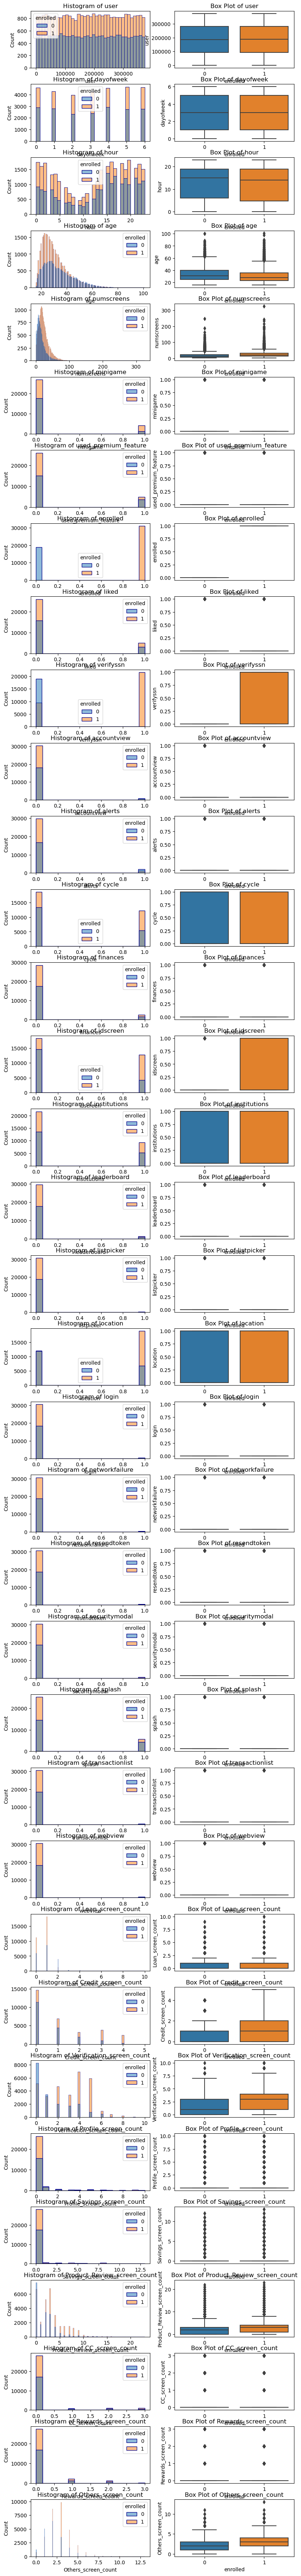

In [30]:
int_columns = df_mobileusebasedata_columns_grouped.select_dtypes('int').columns
num_rows = len(int_columns)

# Creating a subplot grid with rows for each integer column
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 2*num_rows))
fig.tight_layout()

for idx, col in enumerate(int_columns):
    ax1 = axes[idx, 0]  # Left column -> histogram
    ax2 = axes[idx, 1]  # Right column -> box plot
    bar_color = 'lightblue'
    edge_color = 'darkblue'

    sns.histplot(data=df_mobileusebasedata_columns_grouped, x=df_mobileusebasedata_columns_grouped[col],
                 hue=df_mobileusebasedata_columns_grouped['enrolled'], color=bar_color, kde=False, edgecolor=edge_color, ax=ax1)
    
    ax1.set_title(f'Histogram of {col}')

    sns.boxplot(data=df_mobileusebasedata_columns_grouped, x='enrolled', y=col, ax=ax2)
    
    ax2.set_title(f'Box Plot of {col}')

plt.show()


#### 'removing outlier from the data :'

In [31]:
def age_outlier_removed(df, col):
    IQR = (np.percentile(df[col],85)-np.percentile(df[col],25))
    lower = np.percentile(df[col],25) - 1.5*IQR
    upper = np.percentile(df[col],85) + 1.5*IQR
    
    print('min age is : ',df.age.min())
    print('max age is : ',df.age.max())
    print('lower bound for column [',col,'] is :', str(lower))
    print('upper bound for column [',col,'] is :', str(upper)) 
    print('Clipping the age to min value of 16 years and max value of 72 years') 
    
    df['age']= df["age"].clip(lower = 16, upper = 72) 
    return(df)    

df_mobileusebasedata_columns_grouped_outlier_removed = age_outlier_removed(df_mobileusebasedata_columns_grouped.copy(), 'age')


min age is :  16
max age is :  101
lower bound for column [ age ] is : -4.5
upper bound for column [ age ] is : 71.5
Clipping the age to min value of 16 years and max value of 72 years


##### Splitting into train and test and then Scaling the data

In [32]:
data_for_model_v1 = df_mobileusebasedata_columns_grouped_outlier_removed.copy()

from sklearn.model_selection import train_test_split
data_for_model_v1_X_train, data_for_model_v1_X_test, data_for_model_v1_y_train, data_for_model_v1_y_test = train_test_split(data_for_model_v1.drop(columns=['enrolled']), data_for_model_v1['enrolled'], test_size=.25)

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = data_for_model_v1_X_train.drop(columns=['user'])
X_test = data_for_model_v1_X_test.drop(columns=['user'])

y_train = data_for_model_v1_y_train.copy()
y_test = data_for_model_v1_y_test.copy()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=data_for_model_v1_X_train.drop(columns=['user']).columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=data_for_model_v1_X_test.drop(columns=['user']).columns)


In [34]:
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)

(37405, 33) (12469, 33)
(37405,) (12469,)


In [35]:
y_train.value_counts(True)

enrolled
1    0.623473
0    0.376527
Name: proportion, dtype: float64

In [36]:
y_test.value_counts(True)

enrolled
1    0.616168
0    0.383832
Name: proportion, dtype: float64

##### Data is imbalanced, so we will be oversampling the minority class while training the model

### Building logistic regression model

In [37]:
def simple_logistic_regression(X_train, X_test, y_train, y_test):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=3)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    model = LogisticRegression()
    model.fit(X_res, y_res) # fitting the model
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print("Train Accuracy: {:.2f}%".format(train_accuracy * 100)) #train accuracy
    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100)) #test accuracy
    y_pred = model.predict(X_test)
    # Classification Report
    classification_rep = classification_report(y_test, y_pred)
    print('Classification Report:\n', classification_rep)
    y_score = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_score)
    print('ROC AUC Score: {:.4f}'.format(roc_auc))
simple_logistic_regression(X_train, X_test, y_train, y_test)

Train Accuracy: 83.05%
Test Accuracy: 82.43%
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.97      0.81      4786
           1       0.97      0.73      0.84      7683

    accuracy                           0.82     12469
   macro avg       0.83      0.85      0.82     12469
weighted avg       0.87      0.82      0.83     12469

ROC AUC Score: 0.9109


#### Logistic regression with Grid Search 

In [44]:
def logistic_with_GridSearchCV(X_train, X_test,  y_train, y_test):
    
  
    
    param_grid = {'penalty': ['l1', 'l2'],
                       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'solver':['liblinear']}
    
    
    
    sm = SMOTE(sampling_strategy='auto', k_neighbors=3)
    X_res, y_res = sm.fit_resample(X_train,y_train)
#     print(y_res.value_counts())
#     print(y_train.value_counts())
    
    
    lr = LogisticRegression()
    clf = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_res, y_res)
    print(clf.best_params_)
#     print(pd.DataFrame(clf.cv_results_))
#     pd.DataFrame(clf.cv_results_).to_excel('RegularizedLogistiRegression_Results_20230920.xlsx')
    print('\n\n')
    
    
    model = LogisticRegression(**clf.best_params_)
    model.fit(X_res,y_res)
    print(model)
    print('\n')
    acc = model.score(X_test,y_test)*100
    print("Train Accuracy {:.2f}%".format(model.score(X_res,y_res)*100))
    print("Test Accuracy {:.2f}%".format(acc))
    
    
    col_w_coeff = dict(zip(list(X_train.columns),list(model.coef_[0])))
    print('coeff is : ')
    keys = list(col_w_coeff.keys())
    values = list(col_w_coeff.values())
    sorted_value_index = np.argsort(values)
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    print(sorted_dict)
    
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm_lr = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(3,3))
    plt.title("Logistic Regression Confusion Matrix")
    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 15});
    plt.show()
    print('\n\n')

    # Classification Report
    matrix = classification_report(y_test,y_pred)
    print('Classification report : \n',matrix)
    print('\n\n')
    
    
    # ROC AUC Curve
    y_score = model.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
    print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score))
    


{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}



LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


Train Accuracy 85.91%
Test Accuracy 82.29%
coeff is : 
{'Loan_screen_count': -3.8901130624419653, 'Credit_screen_count': -2.152114625342306, 'Verification_screen_count': -1.1400528061282158, 'webview': -1.0343891687419142, 'login': -0.6813891015473935, 'location': -0.6393651557215574, 'used_premium_feature': -0.45449600087948594, 'alerts': -0.43709587088665375, 'age': -0.396603130615089, 'hour': -0.276678142231875, 'accountview': -0.23028950194972725, 'splash': -0.21696111303896465, 'transactionlist': -0.1512887012495214, 'listpicker': -0.08974697016659519, 'finances': -0.07290512369880786, 'leaderboard': -0.06379168582998644, 'liked': -0.013089758160762544, 'CC_screen_count': 0.0, 'resendtoken': 0.0, 'numscreens': 0.0, 'securitymodal': 0.0, 'dayofweek': 0.1363906143653983, 'Rewards_screen_count': 0.14174913985339405, 'Profile_screen_count': 0.17118460938955377, 'cycle': 

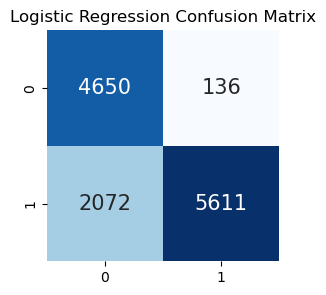




Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.97      0.81      4786
           1       0.98      0.73      0.84      7683

    accuracy                           0.82     12469
   macro avg       0.83      0.85      0.82     12469
weighted avg       0.87      0.82      0.83     12469




roc_auc_score for Logistic Regression:  0.91059037055397


In [45]:
logistic_with_GridSearchCV(X_train, X_test,  y_train, y_test)

# Gradient Boosting Classifier

#### GBM simple

In [46]:
def simple_GBM(X_train, X_test,  y_train, y_test):
    
    
    sm = SMOTE(sampling_strategy='auto', k_neighbors=3)
    X_res, y_res = sm.fit_resample(X_train,y_train)
    
    model = GradientBoostingClassifier()
    model.fit(X_res,y_res)
    acc = model.score(X_test,y_test)*100
    print("Train Accuracy {:.2f}%".format(model.score(X_train,y_train)*100))
    print("Test Accuracy {:.2f}%".format(acc))
    
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm_lr = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(3,3))
    plt.title("GBM Confusion Matrix")
    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 15});
    plt.show()
    print('\n\n')
    
    
    # Classification Report
    matrix = classification_report(y_test,y_pred)
    print('Classification report : \n',matrix)
    print('\n\n')
    
    
    # ROC AUC Curve
    y_score = model.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
    print('roc_auc_score for GBM: ', roc_auc_score(y_test, y_score))


Train Accuracy 84.61%
Test Accuracy 83.78%


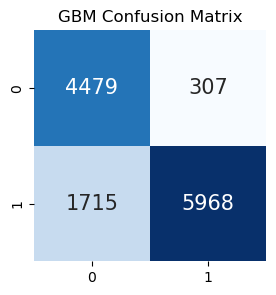




Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      4786
           1       0.95      0.78      0.86      7683

    accuracy                           0.84     12469
   macro avg       0.84      0.86      0.84     12469
weighted avg       0.86      0.84      0.84     12469




roc_auc_score for GBM:  0.921663411641584


In [47]:
simple_GBM(X_train, X_test,  y_train, y_test)

In [55]:
def GBM_with_GridSearchCV_regularize(X_train, X_test,  y_train, y_test):
   
    
    param_grid = {'n_estimators':[100],
                  'max_depth':[1,2,3]}    
    
 
    
    sm = SMOTE(sampling_strategy='auto', k_neighbors=3)
    X_res, y_res = sm.fit_resample(X_train,y_train)
    
    
    gbm = GradientBoostingClassifier()
    clf = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_res, y_res)
    print(clf.best_params_)
#     print(pd.DataFrame(clf.cv_results_))
    pd.DataFrame(clf.cv_results_).to_excel('CV_GradientBoostingClassifier_Results_20230920.xlsx')
    
    model = GradientBoostingClassifier(**clf.best_params_)
    model.fit(X_res,y_res)
    print(model)
    acc = model.score(X_test,y_test)*100
    print("Train Accuracy {:.2f}%".format(model.score(X_res,y_res)*100))
    print("Test Accuracy {:.2f}%".format(acc))
    

    # Confusion Matriz
    y_pred = model.predict(X_test)
    cm_lr = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(3,3))
    plt.title("GBM Confusion Matrix")
    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 15});
    print('\n\n')
    
    # Classification Report
    matrix = classification_report(y_test,y_pred)
    print('Classification report : \n',matrix)
    print('\n\n')
    
    
    # ROC AUC Curve
    y_score = model.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
    print('roc_auc_score for GBM: ', roc_auc_score(y_test, y_score))
    

{'max_depth': 3, 'n_estimators': 100}
GradientBoostingClassifier()
Train Accuracy 87.54%
Test Accuracy 83.87%



Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      4786
           1       0.95      0.78      0.86      7683

    accuracy                           0.84     12469
   macro avg       0.84      0.86      0.84     12469
weighted avg       0.86      0.84      0.84     12469




roc_auc_score for GBM:  0.9214800734212258


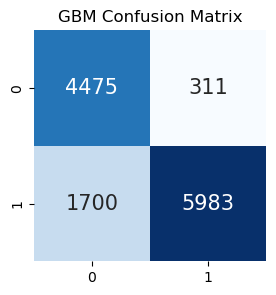

In [56]:
GBM_with_GridSearchCV_regularize(X_train, X_test,  y_train, y_test)

In [54]:
X_train.columns

Index(['dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'liked', 'verifyssn', 'accountview', 'alerts',
       'cycle', 'finances', 'idscreen', 'institutions', 'leaderboard',
       'listpicker', 'location', 'login', 'networkfailure', 'resendtoken',
       'securitymodal', 'splash', 'transactionlist', 'webview',
       'Loan_screen_count', 'Credit_screen_count', 'Verification_screen_count',
       'Profile_screen_count', 'Savings_screen_count',
       'Product_Review_screen_count', 'CC_screen_count',
       'Rewards_screen_count', 'Others_screen_count'],
      dtype='object')

# Neural Network

In [51]:
def neural_network_adam_implementation(X_train, X_test,  y_train, y_test):
    import keras
    from keras.models import Sequential   # importing Sequential model
    from keras.layers import Dense        # importing Dense layers
    
    
    # declaring model
    basic_model = Sequential()
    
    # Adding layers to the model
    basic_model.add(Dense(units = 10 , activation = 'relu', input_shape = (33,))) 
    basic_model.add(Dense(units = 20 , activation = 'relu', ))
    basic_model.add(Dense(1, activation = 'sigmoid'))
    
    
    # compiling the model
    basic_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
                        
    
    # training the model
    basic_model.fit(X_train, y_train, epochs=100, batch_size=15)

                        
    # Test, Loss and accuracy
    loss_and_metrics = basic_model.evaluate(X_test, y_test)
    print('Loss = ',loss_and_metrics[0])
    print('Accuracy = ',loss_and_metrics[1])

In [60]:
neural_network_adam_implementation(X_train, X_test,  y_train, y_test)

Epoch 1/100
2494/2494 [==============================] - 1s 422us/step - loss: 0.3497 - accuracy: 0.8196
Epoch 2/100
2494/2494 [==============================] - 1s 373us/step - loss: 0.3205 - accuracy: 0.8390
Epoch 3/100
2494/2494 [==============================] - 1s 469us/step - loss: 0.3180 - accuracy: 0.8413
Epoch 4/100
2494/2494 [==============================] - 1s 400us/step - loss: 0.3159 - accuracy: 0.8425
Epoch 5/100
2494/2494 [==============================] - 1s 386us/step - loss: 0.3147 - accuracy: 0.8443
Epoch 6/100
2494/2494 [==============================] - 1s 405us/step - loss: 0.3130 - accuracy: 0.8455
Epoch 7/100
2494/2494 [==============================] - 1s 389us/step - loss: 0.3119 - accuracy: 0.8456
Epoch 8/100
2494/2494 [==============================] - 1s 380us/step - loss: 0.3112 - accuracy: 0.8465
Epoch 9/100
2494/2494 [==============================] - 1s 364us/step - loss: 0.3104 - accuracy: 0.8465
Epoch 10/100
2494/2494 [==============================]

2494/2494 [==============================] - 1s 339us/step - loss: 0.2969 - accuracy: 0.8566
Epoch 79/100
2494/2494 [==============================] - 1s 337us/step - loss: 0.2968 - accuracy: 0.8561
Epoch 80/100
2494/2494 [==============================] - 1s 339us/step - loss: 0.2964 - accuracy: 0.8558
Epoch 81/100
2494/2494 [==============================] - 1s 337us/step - loss: 0.2966 - accuracy: 0.8561
Epoch 82/100
2494/2494 [==============================] - 1s 339us/step - loss: 0.2961 - accuracy: 0.8569
Epoch 83/100
2494/2494 [==============================] - 1s 338us/step - loss: 0.2962 - accuracy: 0.8566
Epoch 84/100
2494/2494 [==============================] - 1s 337us/step - loss: 0.2965 - accuracy: 0.8565
Epoch 85/100
2494/2494 [==============================] - 1s 338us/step - loss: 0.2962 - accuracy: 0.8561
Epoch 86/100
2494/2494 [==============================] - 1s 339us/step - loss: 0.2961 - accuracy: 0.8573
Epoch 87/100
2494/2494 [==============================] - 1

In [61]:
def neural_network_sgd_implementation(X_train, X_test,  y_train, y_test):
    import keras
    from keras.models import Sequential   # importing Sequential model
    from keras.layers import Dense        # importing Dense layers
    
    
    X_train = data_for_model_v1_X_train.drop(columns=['user'])
    X_test = data_for_model_v1_X_test.drop(columns=['user'])
    
    y_train = data_for_model_v1_y_train.copy()
    y_test = data_for_model_v1_y_test.copy()
    
    
    
    # declaring model
    basic_model = Sequential()
    
    
    # Adding layers to the model
    basic_model.add(Dense(units = 10 , activation = 'relu', input_shape = (33,))) 
    basic_model.add(Dense(units = 20 , activation = 'relu', ))
    basic_model.add(Dense(1, activation = 'sigmoid'))
    
    
    
    basic_model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
                        
    
    # training the model
    basic_model.fit(X_train, y_train, epochs=100, batch_size=15)

                        
    # Test, Loss and accuracy
    loss_and_metrics = basic_model.evaluate(X_test, y_test)
    print('Loss = ',loss_and_metrics[0])
    print('Accuracy = ',loss_and_metrics[1])

In [62]:
neural_network_sgd_implementation(X_train, X_test,  y_train, y_test)

Epoch 1/100
2494/2494 [==============================] - 1s 295us/step - loss: 0.5830 - accuracy: 0.6888
Epoch 2/100
2494/2494 [==============================] - 1s 286us/step - loss: 0.5104 - accuracy: 0.7261
Epoch 3/100
2494/2494 [==============================] - 1s 316us/step - loss: 0.4556 - accuracy: 0.7522
Epoch 4/100
2494/2494 [==============================] - 1s 325us/step - loss: 0.5446 - accuracy: 0.7110
Epoch 5/100
2494/2494 [==============================] - 1s 309us/step - loss: 0.4961 - accuracy: 0.7298
Epoch 6/100
2494/2494 [==============================] - 1s 294us/step - loss: 0.4465 - accuracy: 0.7555
Epoch 7/100
2494/2494 [==============================] - 1s 289us/step - loss: 0.4514 - accuracy: 0.7516
Epoch 8/100
2494/2494 [==============================] - 1s 287us/step - loss: 0.4090 - accuracy: 0.7795
Epoch 9/100
2494/2494 [==============================] - 1s 317us/step - loss: 0.4174 - accuracy: 0.7749
Epoch 10/100
2494/2494 [==============================]

2494/2494 [==============================] - 1s 300us/step - loss: 0.3242 - accuracy: 0.8400
Epoch 79/100
2494/2494 [==============================] - 1s 302us/step - loss: 0.3268 - accuracy: 0.8392
Epoch 80/100
2494/2494 [==============================] - 1s 306us/step - loss: 0.3251 - accuracy: 0.8384
Epoch 81/100
2494/2494 [==============================] - 1s 322us/step - loss: 0.3241 - accuracy: 0.8390
Epoch 82/100
2494/2494 [==============================] - 1s 309us/step - loss: 0.3253 - accuracy: 0.8388
Epoch 83/100
2494/2494 [==============================] - 1s 313us/step - loss: 0.3233 - accuracy: 0.8385
Epoch 84/100
2494/2494 [==============================] - 1s 332us/step - loss: 0.3251 - accuracy: 0.8385
Epoch 85/100
2494/2494 [==============================] - 1s 338us/step - loss: 0.3232 - accuracy: 0.8396
Epoch 86/100
2494/2494 [==============================] - 1s 309us/step - loss: 0.3227 - accuracy: 0.8418
Epoch 87/100
2494/2494 [==============================] - 1

In [63]:
def neural_network_rmsprop_implementation(X_train, X_test,  y_train, y_test):
    import keras
    from keras.models import Sequential   # importing Sequential model
    from keras.layers import Dense        # importing Dense layers
    
    
    X_train = data_for_model_v1_X_train.drop(columns=['user'])
    X_test = data_for_model_v1_X_test.drop(columns=['user'])
    
    y_train = data_for_model_v1_y_train.copy()
    y_test = data_for_model_v1_y_test.copy()
    
    
    
    # declaring model
    basic_model = Sequential()
    
    
    # Adding layers to the model
    basic_model.add(Dense(units = 10 , activation = 'relu', input_shape = (33,))) 
    basic_model.add(Dense(units = 20 , activation = 'relu', ))
    basic_model.add(Dense(1, activation = 'sigmoid'))
    
    
    
    # compiling the model
    basic_model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
                        
    
    # training the model
    basic_model.fit(X_train, y_train, epochs=100, batch_size=15)

                        
    # Test, Loss and accuracy
    loss_and_metrics = basic_model.evaluate(X_test, y_test)
    print('Loss = ',loss_and_metrics[0])
    print('Accuracy = ',loss_and_metrics[1])

In [64]:
neural_network_rmsprop_implementation(X_train, X_test,  y_train, y_test)

Epoch 1/100
2494/2494 [==============================] - 1s 317us/step - loss: 0.4606 - accuracy: 0.7650
Epoch 2/100
2494/2494 [==============================] - 1s 312us/step - loss: 0.3352 - accuracy: 0.8313
Epoch 3/100
2494/2494 [==============================] - 1s 312us/step - loss: 0.3296 - accuracy: 0.8352
Epoch 4/100
2494/2494 [==============================] - 1s 317us/step - loss: 0.3272 - accuracy: 0.8356
Epoch 5/100
2494/2494 [==============================] - 1s 344us/step - loss: 0.3247 - accuracy: 0.8376
Epoch 6/100
2494/2494 [==============================] - 1s 320us/step - loss: 0.3232 - accuracy: 0.8408
Epoch 7/100
2494/2494 [==============================] - 1s 313us/step - loss: 0.3229 - accuracy: 0.8419
Epoch 8/100
2494/2494 [==============================] - 1s 311us/step - loss: 0.3219 - accuracy: 0.8407
Epoch 9/100
2494/2494 [==============================] - 1s 311us/step - loss: 0.3213 - accuracy: 0.8401
Epoch 10/100
2494/2494 [==============================]

2494/2494 [==============================] - 1s 320us/step - loss: 0.3193 - accuracy: 0.8484
Epoch 79/100
2494/2494 [==============================] - 1s 324us/step - loss: 0.3187 - accuracy: 0.8463
Epoch 80/100
2494/2494 [==============================] - 1s 313us/step - loss: 0.3184 - accuracy: 0.8475
Epoch 81/100
2494/2494 [==============================] - 1s 313us/step - loss: 0.3184 - accuracy: 0.8492
Epoch 82/100
2494/2494 [==============================] - 1s 315us/step - loss: 0.3192 - accuracy: 0.8474
Epoch 83/100
2494/2494 [==============================] - 1s 315us/step - loss: 0.3196 - accuracy: 0.8481
Epoch 84/100
2494/2494 [==============================] - 1s 326us/step - loss: 0.3188 - accuracy: 0.8473
Epoch 85/100
2494/2494 [==============================] - 1s 318us/step - loss: 0.3189 - accuracy: 0.8477
Epoch 86/100
2494/2494 [==============================] - 1s 315us/step - loss: 0.3203 - accuracy: 0.8481
Epoch 87/100
2494/2494 [==============================] - 1


## Answer1 a:
- After EDA, it was evident from the correlation matrix that 'verifyssn' column has highest correlation with the target variable and thus can be useful in making prediction
- There were moderately high correlation b/w columns that are similarly named. I will combine these under single column by aggregating the counts to reduce multicollinearity.
- Histogram suggests that 'age' columns have some extreme value (skewed) and thus needs to be processed to have values that are relevant for business.
- low enroll and numscreens
- First open date ,hour ,dayofweek doesn't seem to be of much use here .Enrolled date can't be used because of data leakage.

## Answer1 b:
- Data scaling is a good thing to normalize each column so that every column gets proper representation in the data. Some columns have a binary format, whereas some columns have a higher range of values. Hence, bringing each column to the correct range is required for logistic regression models.
- The Screenlist column is a categorical variable and needs to be encoded with distinct values to perform any of the ML models.
- Dayofweek is provided as an ordinal categorical variable, but it should be nominal, and one-hot label encoding could be done to give equal representation to all days of the week.



## Answer2 a:
- Building the following model and got the mentioned test accuracy:
    - simple logistic regression (83%)
    - simple GBM (84.5%)
    - logistic regression with GridsearchCV (83%)
    - GBM with Grid search CV (85.3%)
- Taking accuracy here as evaluation metric and not others such as precision or recall because the problem statement requires the overall scenario and not specificaly focussing on any class in the enrolled column.
    
- Most of the models gives accuracy in a similar range. However, GBM is slightly better compared to others, so going ahead with GBM


## Answer2 b:
- I am building the following model and am getting the following test accuracy:
    - simple logistic regression (83%)
    - logistic regression with GridsearchCV (83%)
    
- There isn't much difference b/w the accuracy number b/w regularized and simple model. Lower value of 'C' will have higher impact on the regularization. The original model itself with the default value was not overfitting, So in this case explicit regularization was not needed.

## Answer3:

- All 3 models in neural network (adam, rmsprop, sgd) are giving similar results for accuracy on the test dataset and hovers around 85%.
- There processing seems to differ in the way they reach the optimized value.
   - adam seems to reach the near optimum value in fewer iteration
   - SGD starts very far off but slowly gets near the optimum value
   - rmsprop performs somewhat b/w adam and sgd when it comes to number of iterations required to reach near the optimum value